# Noise correction between events
Using the calibration baseflow levels al reference, and find a scaling factor for the other events

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
from scipy.signal import butter, filtfilt, hilbert, spectrogram
from scipy.ndimage import gaussian_filter1d

# function definition
def gain_compensation(data, gain):
    linear_gain = 10 ** (gain / 20)
    calibrated_data = data / linear_gain
    return calibrated_data

def storm_noise(folder, channel, gain_db, segment_duration_sec=60):
    """
    folder : str (Path to the folder containing .flac recordings)
    channel : str (Channel to use: 'left' or 'right')
    gain_db : float (Gain value (in dB) used in the field for the selected channel)
    -------
    Returns a DataFrame with columns ['filename', 'rms', 'rms_dB', 'date_str'].
    """
    results = []
    for filename in os.listdir(folder):
        if filename.endswith(".flac"):
            filepath = os.path.join(folder, filename)
            data, samplerate = sf.read(filepath)

            # select the channel from input
            if data.ndim == 2:
                if channel.lower() == "left":
                    data = data[:, 0]
                elif channel.lower() == "right":
                    data = data[:, 1]
                else:
                    raise ValueError("must be 'left' or 'right'.")

            # apply gain compensation
            data = gain_compensation(data, gain_db)

            # compute RMS amplitude
            rms = np.sqrt(np.mean(data ** 2))
            rms_db = 20 * np.log10(rms)

            # extract datetime info from filename (e.g., raspberrypi_072321-081600)
            try:
                date_str = filename.split("_")[1].split(".")[0]
            except:
                date_str = filename

            results.append({
                "filename": filename,
                "rms": rms,
                "rms_dB": rms_db,
                "date_str": date_str
            })
    noise_df = pd.DataFrame(results)
    return noise_df

def calibration_noise(data, samplerate, channel, gain_db, segment_duration_sec=60):
    """
    data : 2D array (audio data)
    samplerate : int (sampling rate in Hz)
    channel : str (Channel to use: 'left' or 'right')
    gain_db : float (Gain value (in dB) used in the field for the selected channel)
    segment_duration_sec : int (length of each segment in seconds)
    -------
    Returns a DataFRame with columns ['minute', 'rms', 'rms_dB' and 'recording'].
    """
    # select the channel from input
    if data.ndim == 2:
        if channel.lower() == "left":
            data = data[:, 0]
        elif channel.lower() == "right":
            data = data[:, 1]
        else:
            raise ValueError("must be 'left' or 'right'.")
    # apply gain compensation
    data = gain_compensation(data, gain_db)
    
    samples_per_segment = samplerate * segment_duration_sec
    total_segments = int(len(data) / samples_per_segment)
    
    results = []
    
    for i in range(total_segments):
        start = int(i * samples_per_segment)
        end = int(start + samples_per_segment)
        segment = data[start:end]

        rms = np.sqrt(np.mean(segment**2))
        rms_db = 20 * np.log10(rms)

        results.append({
            "minute": i,             # minute index (0 to 19)
            "rms": rms,
            "rms_dB": rms_db
        })

    return pd.DataFrame(results)

### Import discharge data

In [2]:
# import shear stress data, making first column date_time and the index
tau_2022 = pd.read_csv('../mobile_shear_stress_2022.csv', index_col=0, parse_dates=True)
tau_2023 = pd.read_csv('../mobile_shear_stress_2023.csv', index_col=0, parse_dates=True)
tau_calibration = pd.read_csv('../../Shear Stress/stress_partitioning/flood_experiments_2023/calibration_experiments_shear_stress.csv', index_col=0, parse_dates=True)
# give the second column a name
tau_2022.columns = ['tau']
tau_2023.columns = ['tau']
tau_calibration.rename(columns={'shear_stress': 'tau'}, inplace=True)

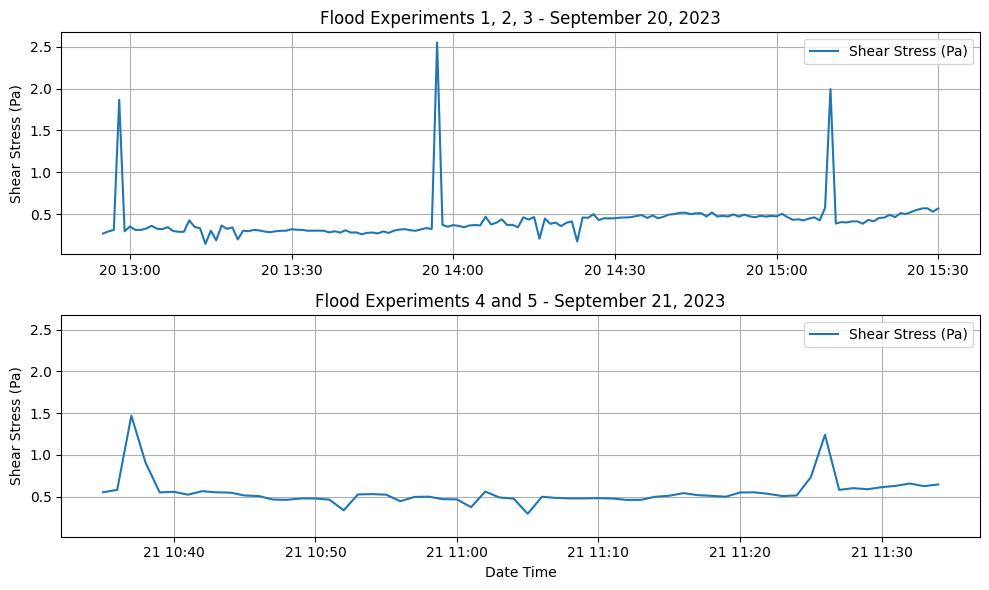

In [3]:
# plot shear stress during flood events - separated by days
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=False, sharey=True)

# Day 1: 2023-09-20
day1_data = tau_calibration.loc['2023-09-20 12:55:00':'2023-09-20 15:30:00']
ax1.plot(day1_data.index, day1_data['tau'], label='Shear Stress (Pa)')
ax1.set_ylabel('Shear Stress (Pa)')
ax1.set_title('Flood Experiments 1, 2, 3 - September 20, 2023')
ax1.legend()
ax1.grid(True)

# Day 2: 2023-09-21
day2_data = tau_calibration.loc['2023-09-21 10:35:00':'2023-09-21 11:34:00']
ax2.plot(day2_data.index, day2_data['tau'], label='Shear Stress (Pa)')
ax2.set_xlabel('Date Time')
ax2.set_ylabel('Shear Stress (Pa)')
ax2.set_title('Flood Experiments 4 and 5 - September 21, 2023')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [4]:
# periods of baseflow: 
experiment_baseflow = pd.concat([
    tau_calibration.loc['2023-09-20 13:00:00':'2023-09-20 13:10:00'],
    tau_calibration.loc['2023-09-20 13:30:00':'2023-09-20 13:45:00'],
    tau_calibration.loc['2023-09-20 14:30:00':'2023-09-20 15:00:00'],
    tau_calibration.loc['2023-09-20 15:15:00':'2023-09-20 15:30:00'],  
    tau_calibration.loc['2023-09-21 10:40:00':'2023-09-21 10:50:00'],
    tau_calibration.loc['2023-09-21 11:10:00':'2023-09-21 11:20:00'],
    tau_calibration.loc['2023-09-21 11:30:00':'2023-09-21 11:34:00']
])['tau']

### Import calibration recordings

In [5]:
# all sample rates for these recordings are 44100 Hz and they are all 20 minutes
flood_files = {
#"flood1": "../Calibration/EXP-09-20-23-FLOW1//audio/Nicole_091823-000100.flac",
#"flood11": "../Calibration/EXP-09-20-23-FLOW1//audio/Nicole_091823-002300.flac",
"flood2": "../Calibration/EXP-09-20-23-FLOW2//audio/Nicole_091823-000100.flac",
"flood3": "../Calibration/EXP-09-20-23-FLOW3//audio/Nicole_091823-000100.flac",
"flood4": "../Calibration/EXP-09-21-23-FLOW4//audio/Nicole_091823-000100.flac",
"flood44": "../Calibration/EXP-09-21-23-FLOW4//audio/Nicole_091823-002300.flac",
"flood5": "../Calibration/EXP-09-21-23-FLOW5//audio/Nicole_091823-000100.flac",
"flood55": "../Calibration/EXP-09-21-23-FLOW5//audio/Nicole_091823-002300.flac"
}

flood_rec_start_times = {
    #"flood1": "2023-09-20 12:56:00",
    #"flood11": "2023-09-20 13:16:00",  
    "flood2": "2023-09-20 13:54:00",   
    "flood3": "2023-09-20 15:05:00",   
    "flood4": "2023-09-21 10:26:00",   
    "flood44": "2023-09-21 10:46:00",  
    "flood5": "2023-09-21 11:24:00",   
    "flood55": "2023-09-21 11:44:00"   
}

Calculate noise and store as a time series

In [6]:
flood_results = []

for label, path in flood_files.items():
    data, samplerate = sf.read(path)
    ts_df = calibration_noise(data, samplerate, channel="left", segment_duration_sec=60)
    ts_df["recording"] = label
    flood_results.append(ts_df)

# combine all results into one DataFrame
calibration_df = pd.concat(flood_results, ignore_index=True)
print(calibration_df.head())

   minute       rms     rms_dB recording
0       0  0.000298 -70.521526    flood2
1       1  0.000452 -66.895728    flood2
2       2  0.000290 -70.752682    flood2
3       3  0.005072 -45.895866    flood2
4       4  0.000396 -68.046522    flood2


In [7]:
# Add datetime column to calibration_df
calibration_df['Date_Time'] = pd.NaT  # initialize with NaT (Not a Time)

for recording in calibration_df['recording'].unique():
    mask = calibration_df['recording'] == recording
    start_time = pd.to_datetime(flood_rec_start_times[recording])
    # create datetime series for this recording (minute 0, 1, 2, ... becomes actual timestamps)
    minutes_offset = calibration_df.loc[mask, 'minute']
    calibration_df.loc[mask, 'Date_Time'] = start_time + pd.to_timedelta(minutes_offset, unit='min')

# set datetime as index 
calibration_df.set_index('Date_Time', inplace=True)
print(calibration_df.head(10))

                     minute       rms     rms_dB recording
Date_Time                                                 
2023-09-20 13:54:00       0  0.000298 -70.521526    flood2
2023-09-20 13:55:00       1  0.000452 -66.895728    flood2
2023-09-20 13:56:00       2  0.000290 -70.752682    flood2
2023-09-20 13:57:00       3  0.005072 -45.895866    flood2
2023-09-20 13:58:00       4  0.000396 -68.046522    flood2
2023-09-20 13:59:00       5  0.000355 -68.988358    flood2
2023-09-20 14:00:00       6  0.000348 -69.169943    flood2
2023-09-20 14:01:00       7  0.000342 -69.321094    flood2
2023-09-20 14:02:00       8  0.000336 -69.461350    flood2
2023-09-20 14:03:00       9  0.000318 -69.943313    flood2


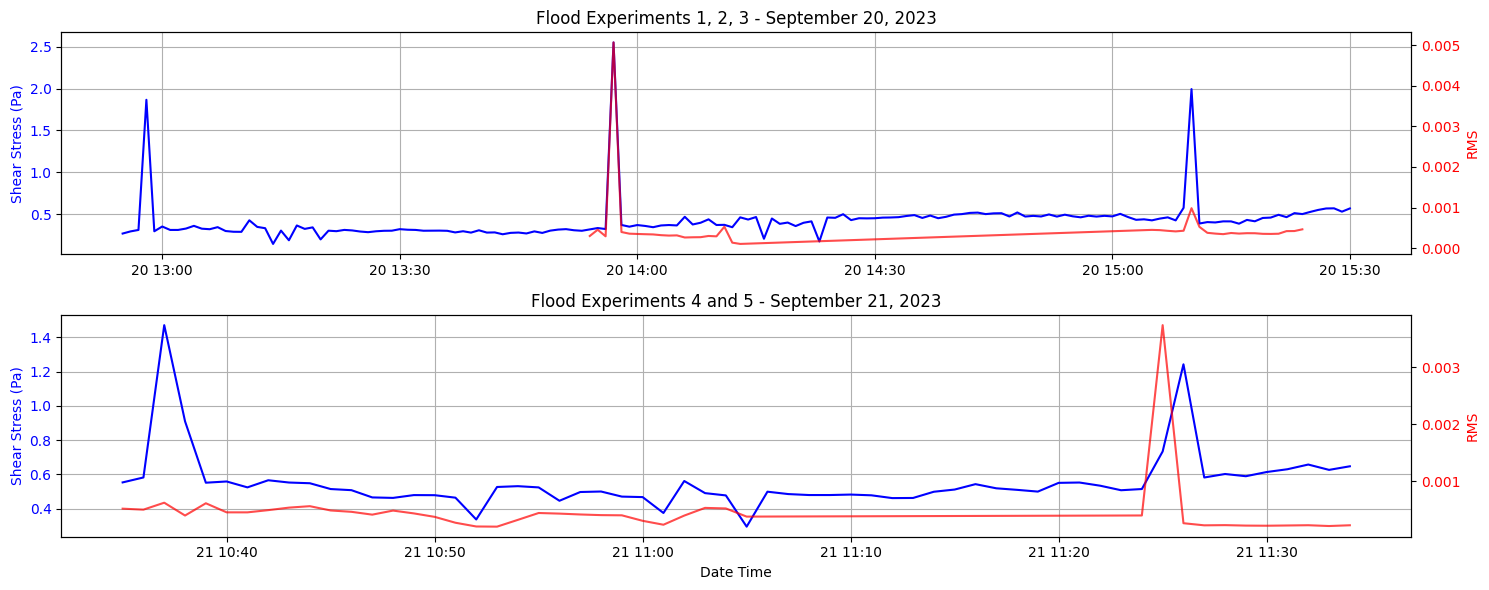

In [8]:
# plot shear stress during flood events - separated by days
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=False)

# Day 1: 2023-09-20
day1_data = tau_calibration.loc['2023-09-20 12:55:00':'2023-09-20 15:30:00']
day1_rms = calibration_df.loc['2023-09-20 12:55:00':'2023-09-20 15:30:00']

ax1.plot(day1_data.index, day1_data['tau'], label='Shear Stress (Pa)', color='blue')
ax1.set_ylabel('Shear Stress (Pa)', color='blue')
ax1.set_title('Flood Experiments 1, 2, 3 - September 20, 2023')
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for RMS
ax1_twin = ax1.twinx()
ax1_twin.plot(day1_rms.index, day1_rms['rms'], label='RMS', color='red', alpha=0.7)
ax1_twin.set_ylabel('RMS', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')

# Day 2: 2023-09-21
day2_data = tau_calibration.loc['2023-09-21 10:35:00':'2023-09-21 11:34:00']
day2_rms = calibration_df.loc['2023-09-21 10:35:00':'2023-09-21 11:34:00']

ax2.plot(day2_data.index, day2_data['tau'], label='Shear Stress (Pa)', color='blue')
ax2.set_xlabel('Date Time')
ax2.set_ylabel('Shear Stress (Pa)', color='blue')
ax2.set_title('Flood Experiments 4 and 5 - September 21, 2023')
ax2.grid(True)
ax2.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for RMS
ax2_twin = ax2.twinx()
ax2_twin.plot(day2_rms.index, day2_rms['rms'], label='RMS', color='red', alpha=0.7)
ax2_twin.set_ylabel('RMS', color='red')
ax2_twin.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()

Merge shear stress data to it

In [9]:
# merge shear stress data with calibration_df on matching timestamps (only keep timestamps that exist in both datasets)
calibration_df = calibration_df.merge(tau_calibration['tau'], left_index=True, right_index=True, how='inner')  
print(calibration_df.head())
calibration_df.to_csv('calibration_experiments_shear_stress_and_rms.csv')

                     minute       rms     rms_dB recording       tau
2023-09-20 13:54:00       0  0.000298 -70.521526    flood2  0.315977
2023-09-20 13:55:00       1  0.000452 -66.895728    flood2  0.332253
2023-09-20 13:56:00       2  0.000290 -70.752682    flood2  0.320386
2023-09-20 13:57:00       3  0.005072 -45.895866    flood2  2.554105
2023-09-20 13:58:00       4  0.000396 -68.046522    flood2  0.369095


Baseflow mask

In [10]:
# baseflow mask - keep only data that matches experiment_baseflow timestamps
baseflow_calibration = calibration_df[calibration_df.index.isin(experiment_baseflow.index)]
print(baseflow_calibration.head())

                     minute       rms     rms_dB recording       tau
2023-09-20 15:15:00      10  0.000372 -68.596354    flood3  0.411935
2023-09-20 15:16:00      11  0.000358 -68.931006    flood3  0.384467
2023-09-20 15:17:00      12  0.000367 -68.704399    flood3  0.429490
2023-09-20 15:18:00      13  0.000366 -68.734774    flood3  0.413191
2023-09-20 15:19:00      14  0.000351 -69.088133    flood3  0.452968


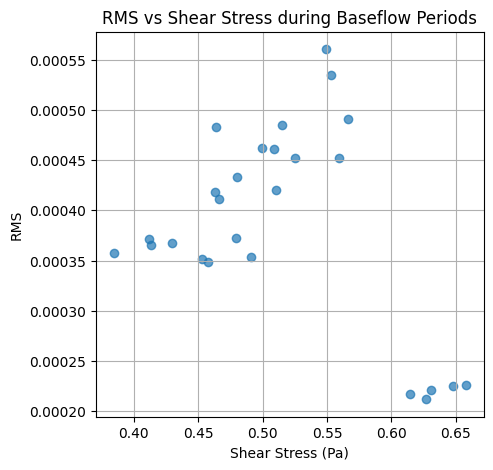

In [ ]:
# scatter plot of rms vs shear stress during baseflow periods
plt.figure(figsize=(4, 6))
plt.scatter(baseflow_calibration['tau'], baseflow_calibration['rms'], alpha=0.7)
plt.xlabel('Shear Stress (Pa)')
plt.ylabel('RMS')
plt.title('RMS vs Shear Stress during Baseflow Periods')
plt.grid(True)
plt.show()

### Import storm recordings

In [12]:
storm2 = compute_rms("../H1/st2/", channel="left", gain_db=24)

LibsndfileError: Error opening '../H1/st2/raspberrypi_080322-211600.flac': Format not recognised.

Calculate noise and store as a time series

Merge shear stress data to it 

Baseflow mas

### Find times whith same shear stresses